# GP testing

In [1]:
import os
import csv
import sys
import torch
import pickle
import gpytorch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch import optim
from torch.utils import data
from torchvision import transforms
from torch.nn import functional as F
from gpytorch.kernels import RBFKernel, ScaleKernel, AdditiveKernel

In [2]:
# we need to manually add the project directory to the path when using Jupyter notebooks
#sys.path.append("/home/santeri/repos/HIT_VAE")
sys.path.append("/u/14/mentus1/unix/repos/HIT_VAE")

In [3]:
from hit_vae.models import mnist_conv_vae
from hit_vae.models import losses
from hit_vae.utils import data_loading
from hit_vae.utils import plotting
from hit_vae.basic_kernels.constant_kernel import ConstantKernel
from hit_vae.basic_kernels.categorical_kernel import CategoricalKernel
from hit_vae.basic_kernels.input_warping_kernel import InputWarpKernel

In [4]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu:0'
print(f'using device: {device}')

using device: cuda


## Data

For testing we use a two-component Gaussian mixture model

In [5]:
data_a = np.random.multivariate_normal(mean = [0, 0], cov=[[1, 0], [0, 1]], size=10)
data_b = np.random.multivariate_normal(mean = [4, 2], cov=[[1, 0], [0, 1]], size=10)
data_c = np.random.multivariate_normal(mean = [5, -1], cov=[[0.5, 0], [0, 0.5]], size=10)

data = np.concatenate((data_a, data_b, data_c), axis = 0)

id = np.repeat(np.array([0, 1, 2]), [10, 10, 10], axis=0)# + np.random.normal(loc=0.0, scale=0.05, size=300)

In [6]:
#Z = torch.tensor(data, dtype=torch.float).to(device)
#labels = torch.tensor(id, dtype=torch.float).view(-1, 1).to(device)

# actually, let's use the latent representations from the trained VAE model
Z = pickle.load( open( "../../data/Z.p", "rb" ))
#Z.type(torch.float)
raw_labels = pickle.load( open( "../../data/labels.p", "rb" ))
labels = torch.tensor(raw_labels, dtype=torch.float).view(-1, 1).to(device)

#print(Z)

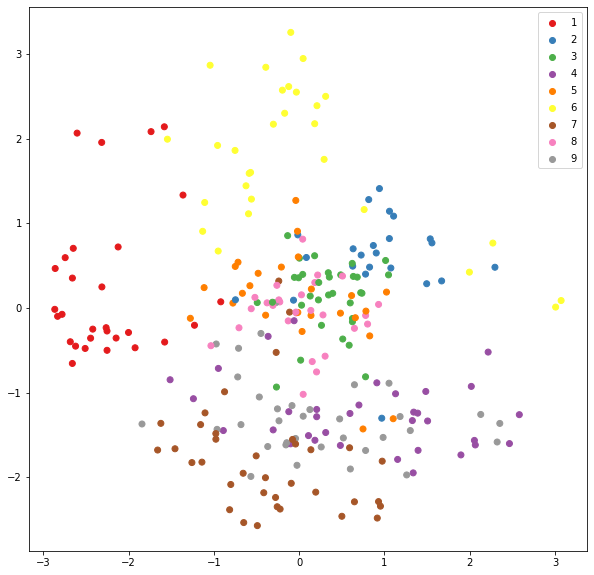

In [7]:
plotting.visualize_latent_2D(Z.detach().cpu().numpy(), raw_labels)

In [8]:
#print(labels)

## GP model

In [9]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, covar_module):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = covar_module
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
#covar_module = ScaleKernel(ConstantKernel(active_dims=0)) * CategoricalKernel(active_dims=0)
covar_module = ScaleKernel(CategoricalKernel(active_dims=0))
#covar_module = ScaleKernel(RBFKernel(active_dims=0))

In [11]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

In [12]:
train_x = Z[:, 0]#.view(-1, 1)
train_y = Z[:, 1]#.view(-1, 1)

#print(train_x)

In [13]:
print(labels.shape)
print(train_x.shape)

#placeholder_targets = torch.zeros(len(labels)).view(-1)

gp_x = ExactGPModel(labels, train_x, likelihood, covar_module).to(device)
gp_y = ExactGPModel(labels, train_y, likelihood, covar_module).to(device)

torch.Size([270, 1])
torch.Size([270])


In [14]:
gp_x

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (quadrature): GaussHermiteQuadrature1D()
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): CategoricalKernel()
    (raw_outputscale_constraint): Positive()
  )
)

## Training the model

In [15]:
gp_x_optimizer = optim.Adam([ {'params': gp_x.parameters()},], lr=0.01)
gp_y_optimizer = optim.Adam([ {'params': gp_y.parameters()},], lr=0.01)

In [16]:
mll_x = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_x)
mll_y = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_y)

In [17]:
for param_name, param in gp_x.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.constant                       value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0


In [18]:
training_iter = 10

for i in range(training_iter):
    # Zero gradients from previous iteration
    gp_x_optimizer.zero_grad()
    gp_y_optimizer.zero_grad()
    
    #gp_x.train_targets = train_x
    #gp_y.train_targets = train_y
    
    # Output from model
    output_x = gp_x(labels)
    output_y = gp_y(labels)
    
    #print(f'gp output {output_x}')
    
    #print(output_x)
    #print(train_x.shape)
    
    # Calc loss and backprop gradients
    loss_x = -mll_x(output_x, train_x)
    loss_y = -mll_y(output_y, train_y)
    
    #print(train_x.shape)
    
    #print(loss_x)
    
    loss = loss_x + loss_y
    
    loss.backward() #.mean().backward()
    if i % 50 == 0:
        print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            #gpmodel.covar_module.base_kernel.lengthscale.item(),
            gp_x.likelihood.noise.item()
        ))
    gp_x_optimizer.step()
    gp_y_optimizer.step()

Iter 1/10 - Loss: 2.323  noise: 0.693


In [19]:
for param_name, param in gp_x.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')
    
#print(gp_x.train_targets)

Parameter name: likelihood.noise_covar.raw_noise           value = -0.19762364029884338
Parameter name: mean_module.constant                       value = -0.06557236611843109
Parameter name: covar_module.raw_outputscale               value = 0.1615041345357895


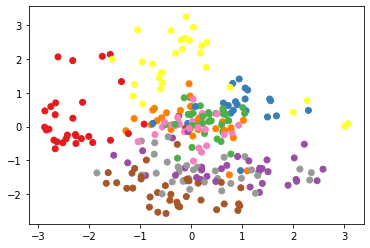

In [20]:
x = gp_x.train_targets.detach().cpu().numpy()
y = gp_y.train_targets.detach().cpu().numpy()

plt.scatter(x, y, c=labels.view(-1).cpu().numpy(), cmap='Set1')

## Evaluating the model

In [21]:
gp_x.eval()
gp_y.eval()

test_ids = np.repeat(np.arange(1, 10), np.repeat(3, 9), axis=0)
#print(test_ids)
test_labels = torch.tensor(test_ids, dtype=torch.float).to(device)

pred_x = likelihood(gp_x(test_labels))
pred_y = likelihood(gp_y(test_labels))

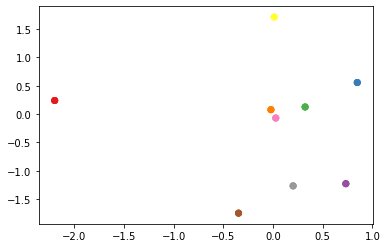

In [22]:
plt.scatter(pred_x.mean.detach().cpu().numpy(), pred_y.mean.detach().cpu().numpy(), 
            c=test_ids, cmap='Set1')

This nicely shows that the model is working as intended